## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Cnidaria - Tim </h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)



# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Chordata** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)


2025-04-07 17:50:31.395506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744044631.527921   33494 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744044631.567686   33494 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744044631.852786   33494 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744044631.852818   33494 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744044631.852820   33494 computation_placer.cc:177] computation placer alr

Memory growth set for GPUs


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Chordata Phylum.

In [3]:
# Load the DataFrame from the CSV file
cnidaria_train = pd.read_csv("train_test_splits/cnidaria_train.csv")
cnidaria_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,28219388,45276311,animalia,cnidaria,acroporidae,cnidaria_acroporidae/28219388_45276311_eol-ful...
1,29729570,45276321,animalia,cnidaria,acroporidae,cnidaria_acroporidae/29729570_45276321_eol-ful...
2,20332243,46545536,animalia,cnidaria,lobophylliidae,cnidaria_lobophylliidae/20332243_46545536_eol-...


In [4]:
# Load the DataFrame from the CSV file
cnidaria_test = pd.read_csv("train_test_splits/cnidaria_test.csv")
cnidaria_test.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,21699228,45276518,animalia,cnidaria,agariciidae,cnidaria_agariciidae/21699228_45276518_eol-ful...
1,2746810,45276959,animalia,cnidaria,siderastreidae,cnidaria_siderastreidae/2746810_45276959_eol-f...
2,29729172,45276583,animalia,cnidaria,fungiidae,cnidaria_fungiidae/29729172_45276583_eol-full-...


In [5]:
cnidaria_train.shape, cnidaria_test.shape

((647, 6), (162, 6))

In [6]:
cnidaria_train['family'].value_counts()

family
acroporidae         168
agariciidae          95
euphylliidae         72
faviidae             48
merulinidae          48
pocilloporidae       48
helioporidae         24
lobophylliidae       24
dendrophylliidae     24
siderastreidae       24
fungiidae            24
diploastraeidae      24
meandrinidae         24
Name: count, dtype: int64

# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

First, we are resizing the images 

In [7]:
def add_resized_images(df, image_folder="rare_species", baseline_size=224):
    df = df.copy()
    column_name = "resized_image"
    df[column_name] = None

    for idx, row in df.iterrows():
        file_path = os.path.join(image_folder, row["file_path"])
        try:
            # Open the image, convert to RGB, and resize it to (baseline_size, baseline_size)
            img = Image.open(file_path).convert("RGB")
            img_resized = img.resize((baseline_size, baseline_size))
            # Store the resulting image as a NumPy array
            df.at[idx, column_name] = np.array(img_resized)
        except Exception as e:
            print(f"Couldn't process image at {file_path}: {e}")
    
    return df

In [8]:
cnidaria_train = add_resized_images(cnidaria_train)
cnidaria_test = add_resized_images(cnidaria_test)

# Check the first few rows of the DataFrame
cnidaria_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,resized_image
0,28219388,45276311,animalia,cnidaria,acroporidae,cnidaria_acroporidae/28219388_45276311_eol-ful...,"[[[76, 74, 72], [72, 70, 71], [76, 72, 74], [8..."
1,29729570,45276321,animalia,cnidaria,acroporidae,cnidaria_acroporidae/29729570_45276321_eol-ful...,"[[[203, 203, 171], [196, 189, 159], [209, 197,..."
2,20332243,46545536,animalia,cnidaria,lobophylliidae,cnidaria_lobophylliidae/20332243_46545536_eol-...,"[[[9, 159, 90], [8, 181, 108], [2, 212, 127], ..."


In [9]:
def show_random_image_pairs(df, image_folder="rare_species", image_column="resized_image", num_samples=5):
    sample_df = df.sample(num_samples, random_state=42).reset_index(drop=True)

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    for i in range(num_samples):
        row = sample_df.loc[i]
        file_path = os.path.join(image_folder, row["file_path"])

        try:
            # Load original image from file
            original_img = Image.open(file_path).convert("RGB")

            # Get the baseline image from the DataFrame
            baseline_img = row[image_column]

            # Plot original image
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")

            # Plot resized image
            axes[i, 1].imshow(baseline_img)
            axes[i, 1].set_title("Resized Image")
            axes[i, 1].axis("off")
        except Exception as e:
            print(f"Error showing image {file_path}: {e}")

    plt.tight_layout()
    plt.show()

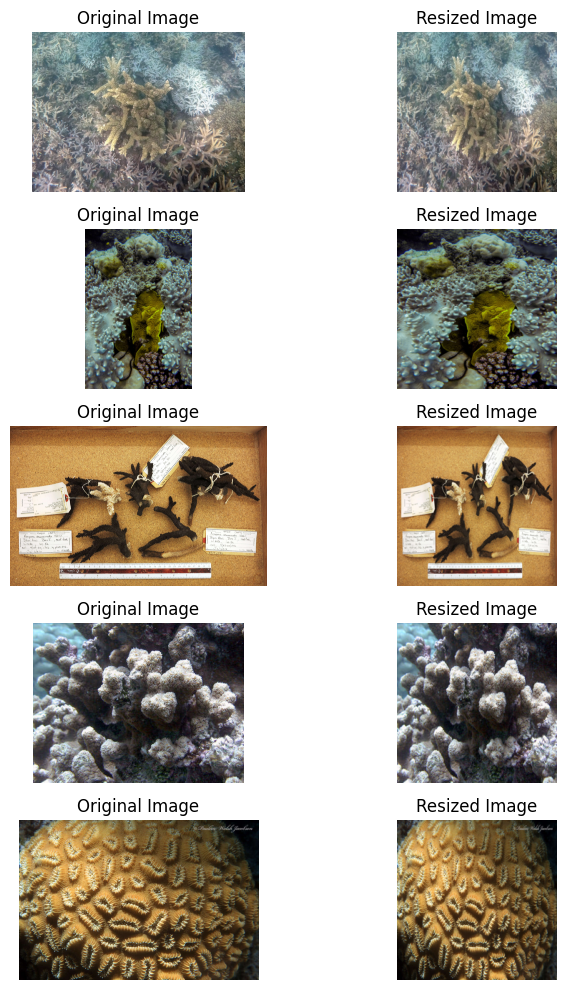

In [10]:

show_random_image_pairs(cnidaria_train)

# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

In [11]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint

## 5.1 Baseline Model 

### 5.1.1 Model Setup

In [13]:
# Prepare input shape and data
input_shape = cnidaria_train['resized_image'].iloc[0].shape

X_train = np.stack(cnidaria_train['resized_image'].values)
X_test = np.stack(cnidaria_test['resized_image'].values)

le = LabelEncoder()
y_train_encoded = le.fit_transform(cnidaria_train['family'])
y_test_encoded = le.transform(cnidaria_test['family'])

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

num_classes = y_train_cat.shape[1]

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.29624542124542125), 1: np.float64(0.5238866396761134), 2: np.float64(2.073717948717949), 3: np.float64(2.073717948717949), 4: np.float64(0.6912393162393162), 5: np.float64(1.0368589743589745), 6: np.float64(2.073717948717949), 7: np.float64(2.073717948717949), 8: np.float64(2.073717948717949), 9: np.float64(2.073717948717949), 10: np.float64(1.0368589743589745), 11: np.float64(1.0368589743589745), 12: np.float64(2.073717948717949)}


In [14]:
# Build the model
input_layer = Input(shape=input_shape)

conv1 = Conv2D(20, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(input_layer)
pool1 = MaxPooling2D(pool_size=(3, 3))(conv1)

conv2 = Conv2D(40, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(pool1)
pool2 = MaxPooling2D(pool_size=(3, 3))(conv2)

conv3 = Conv2D(60, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001))(pool2)

flatten = Flatten()(conv3)

dense1 = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(flatten)
drop1 = Dropout(0.5)(dense1)

dense2 = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(drop1)
drop2 = Dropout(0.5)(dense2)

output_layer = Dense(num_classes, activation="softmax")(drop2)

baseline_model = Model(inputs=input_layer, outputs=output_layer)
baseline_model.summary()

# Compile
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
os.makedirs("models/cnidaria_models", exist_ok=True)

checkpoint = ModelCheckpoint(
    "models/cnidaria_models/baseline_best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

I0000 00:00:1744044683.210903   33494 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5329 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 60)     │        21,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34560)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    17,695,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,859,361 (68.13 MB)

 Trainable params: 17,859,361 (68.13 MB)

 Non-trainable params: 0 (0.00 B)

### 5.1.2 Model Training

In [15]:
# Train
history = baseline_model.fit(
    X_train, y_train_cat,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/40


I0000 00:00:1744044686.803732   33700 service.cc:152] XLA service 0x7f67e400d3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744044686.803778   33700 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-07 17:51:26.869632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744044687.159278   33700 cuda_dnn.cc:529] Loaded cuDNN version 90800


 5/21 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0610 - loss: 221.3004

I0000 00:00:1744044696.852438   33700 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.0789 - loss: 139.4408

2025-04-07 17:51:42.667200: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_155_0', 44 bytes spill stores, 44 bytes spill loads

2025-04-07 17:51:43.070889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_155', 484 bytes spill stores, 484 bytes spill loads

2025-04-07 17:51:45.685706: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_155', 64 bytes spill stores, 64 bytes spill loads




Epoch 1: val_loss improved from inf to 3.68774, saving model to models/cnidaria_models/baseline_best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 632ms/step - accuracy: 0.0808 - loss: 136.1912 - val_accuracy: 0.1543 - val_loss: 3.6877
Epoch 2/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1634 - loss: 3.9289
Epoch 2: val_loss improved from 3.68774 to 3.66587, saving model to models/cnidaria_models/baseline_best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.1653 - loss: 3.9104 - val_accuracy: 0.2037 - val_loss: 3.6659
Epoch 3/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1584 - loss: 3.7214
Epoch 3: val_loss did not improve from 3.66587
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1564 - loss: 3.7323 - val_accuracy: 0.1605 - val_loss: 3.7453
Epoch 4/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1605 - loss: 3.7072
Epoch 4: val_loss improved from 3.66587 to 3.55750, saving model to models/cnidaria_models/baseline_best_model.ker

### 5.1.3 Result Visualizations

In [16]:
#This function is used in notebook 2, notebook 3 and notebook 4
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: History object returned by model.fit() containing training/validation loss values.

    Returns:
    - None (displays a plot of training and validation loss)
    """
    plt.figure(figsize=(7, 2))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


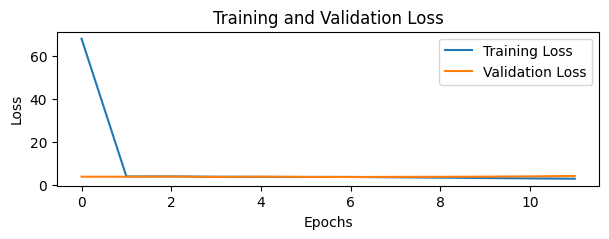

In [17]:
plot_loss(history)

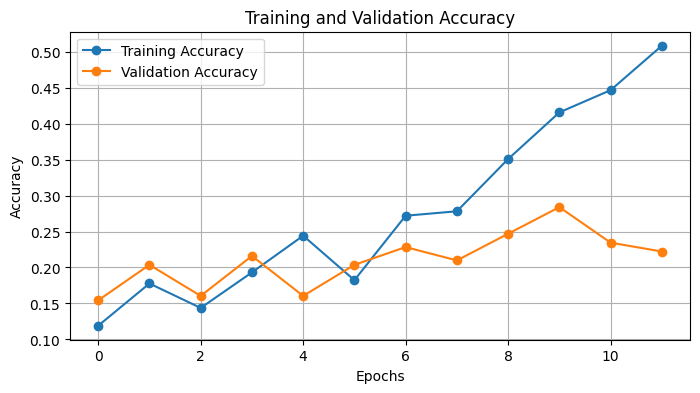

In [18]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

plot_accuracy(history)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


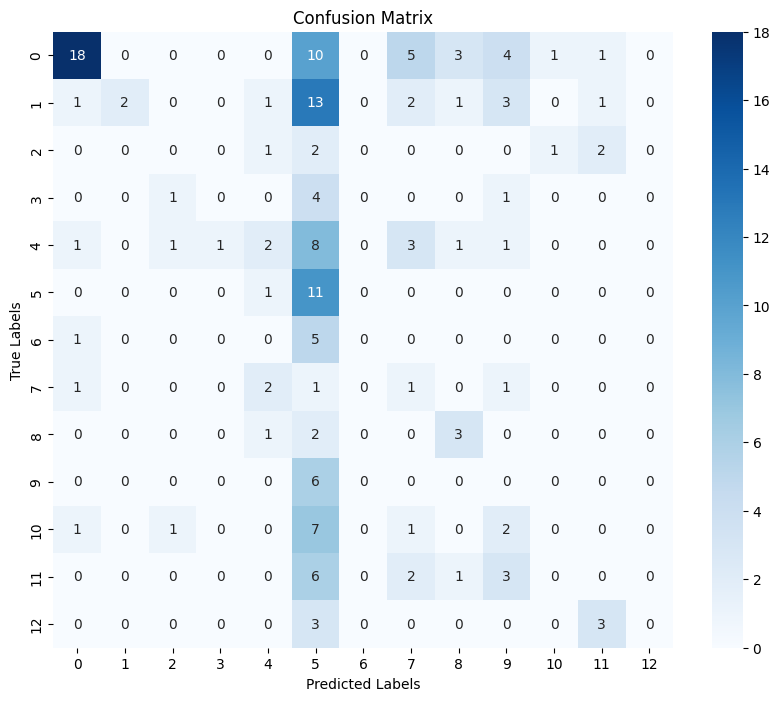

                  precision    recall  f1-score   support

     acroporidae       0.78      0.43      0.55        42
     agariciidae       1.00      0.08      0.15        24
dendrophylliidae       0.00      0.00      0.00         6
 diploastraeidae       0.00      0.00      0.00         6
    euphylliidae       0.25      0.11      0.15        18
        faviidae       0.14      0.92      0.24        12
       fungiidae       0.00      0.00      0.00         6
    helioporidae       0.07      0.17      0.10         6
  lobophylliidae       0.33      0.50      0.40         6
    meandrinidae       0.00      0.00      0.00         6
     merulinidae       0.00      0.00      0.00        12
  pocilloporidae       0.00      0.00      0.00        12
  siderastreidae       0.00      0.00      0.00         6

        accuracy                           0.23       162
       macro avg       0.20      0.17      0.12       162
    weighted avg       0.40      0.23      0.22       162



/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions on the test set
y_pred_probs = baseline_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print the classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))
